# 0. Introduction 

This code focuses on building and improving a multi-class classification model using techniques like resampling (SMOTE and ADASYN) to handle class imbalance, feature engineering (dimensionality reduction and interaction terms) to optimize the feature space, and hyperparameter tuning (grid search for XGBoost) to enhance model performance. It evaluates the model using accuracy, precision, recall, and F1-score to identify areas of improvement, exploring advanced methods like SMOTEENN and incremental PCA to balance the dataset and reduce computational overhead. The goal is to develop a robust pipeline for training and testing a model that effectively handles imbalanced and high-dimensional data.

# 1. Setup and Imports

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.preprocessing import MultiLabelBinarizer

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# 2. Data Loading

In [2]:
# Load dataset
train_data = pd.read_csv("/kaggle/input/eedi-mining-misconceptions-in-mathematics/train.csv")  
test_data = pd.read_csv("/kaggle/input/eedi-mining-misconceptions-in-mathematics/test.csv") 
misconception_mapping = pd.read_csv("/kaggle/input/eedi-mining-misconceptions-in-mathematics/misconception_mapping.csv")  

# Display the first few rows of train data
train_data.head()


,QuestionId,ConstructId,ConstructName,SubjectId,SubjectName,CorrectAnswer,QuestionText,AnswerAText,AnswerBText,AnswerCText,AnswerDText,MisconceptionAId,MisconceptionBId,MisconceptionCId,MisconceptionDId
0,0,856,Use the order of operations to carry out calcu...,33,BIDMAS,A,\[\n3 \times 2+4-5\n\]\nWhere do the brackets ...,\( 3 \times(2+4)-5 \),\( 3 \times 2+(4-5) \),\( 3 \times(2+4-5) \),Does not need brackets,NaN,NaN,NaN,1672.0
1,1,1612,Simplify an algebraic fraction by factorising ...,1077,Simplifying Algebraic Fractions,D,"Simplify the following, if possible: \( \frac{...",\( m+1 \),\( m+2 \),\( m-1 \),Does not simplify,2142.0,143.0,2142.0,NaN
2,2,2774,Calculate the range from a list of data,339,Range and Interquartile Range from a List of Data,B,Tom and Katie are discussing the \( 5 \) plant...,Only\nTom,Only\nKatie,Both Tom and Katie,Neither is correct,1287.0,NaN,1287.0,1073.0
3,3,2377,Recall and use the intersecting diagonals prop...,88,Properties of Quadrilaterals,C,The angles highlighted on this rectangle with ...,acute,obtuse,\( 90^{\circ} \),Not enough information,1180.0,1180.0,NaN,1180.0
4,4,3387,Substitute positive integer values into formul...,67,Substitution into Formula,A,The equation \( f=3 r^{2}+3 \) is used to find...,\( 30 \),\( 27 \),\( 51 \),\( 24 \),NaN,NaN,NaN,1818.0


# 3. Data Exploration

In [3]:
# Summary of the dataset
print("Train Data Info:")
print(train_data.info())

print("\nTest Data Info:")
print(test_data.info())

print("\nMisconception Mapping Info:")
print(misconception_mapping.info())

# Check for missing values
print("\nMissing Values in Train Data:")
print(train_data.isnull().sum())


Train Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1869 entries, 0 to 1868
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   QuestionId        1869 non-null   int64  
 1   ConstructId       1869 non-null   int64  
 2   ConstructName     1869 non-null   object 
 3   SubjectId         1869 non-null   int64  
 4   SubjectName       1869 non-null   object 
 5   CorrectAnswer     1869 non-null   object 
 6   QuestionText      1869 non-null   object 
 7   AnswerAText       1869 non-null   object 
 8   AnswerBText       1869 non-null   object 
 9   AnswerCText       1869 non-null   object 
 10  AnswerDText       1869 non-null   object 
 11  MisconceptionAId  1135 non-null   float64
 12  MisconceptionBId  1118 non-null   float64
 13  MisconceptionCId  1080 non-null   float64
 14  MisconceptionDId  1037 non-null   float64
dtypes: float64(4), int64(3), object(8)
memory usage: 219.1+ KB
None

Test Da

# 4. Preprocessing

In [4]:
# Initialize text preprocessing tools
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

# Function to preprocess text
def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
    tokens = [stemmer.stem(word) for word in tokens]
    return " ".join(tokens)

# Apply preprocessing to relevant columns
train_data['QuestionText'] = train_data['QuestionText'].apply(preprocess_text)
train_data['AnswerAText'] = train_data['AnswerAText'].apply(preprocess_text)
train_data['AnswerBText'] = train_data['AnswerBText'].apply(preprocess_text)
train_data['AnswerCText'] = train_data['AnswerCText'].apply(preprocess_text)
train_data['AnswerDText'] = train_data['AnswerDText'].apply(preprocess_text)


# 5. Feature Engineering

In [5]:
# Combine question and answer text for vectorization
train_data['CombinedText'] = (
    train_data['QuestionText'] + " " +
    train_data['AnswerAText'] + " " +
    train_data['AnswerBText'] + " " +
    train_data['AnswerCText'] + " " +
    train_data['AnswerDText']
)

# TF-IDF vectorization
tfidf = TfidfVectorizer(max_features=10000)
X = tfidf.fit_transform(train_data['CombinedText'])
y = train_data[['MisconceptionAId', 'MisconceptionBId', 'MisconceptionCId']]

# Flatten labels for multi-label classification
mlb = MultiLabelBinarizer()
y_binary = mlb.fit_transform(y.values.tolist())


# 6. Model Training

In [6]:
import numpy as np

# Assuming X_train and y_binary are properly defined
# Replace these with your actual data
# Example setup:
X_train = np.random.rand(100, 5)  # 100 samples with 5 features each (example data)
y_binary = np.random.randint(2, size=(100, 3))  # 100 samples with 3 binary labels (example data)

# Calculate label frequencies
label_counts = y_binary.sum(axis=0)  # Sum along the rows to count occurrences of each label

# Find problematic labels
always_present_labels = np.where(label_counts == X_train.shape[0])[0]  # Labels present in all samples
missing_labels = np.where(label_counts == 0)[0]  # Labels missing in all samples

# Output results
print(f"Always present labels: {always_present_labels}")
print(f"Missing labels: {missing_labels}")





Always present labels: []
Missing labels: []


In [7]:
# Check for labels present in all samples
always_present_labels = np.where((y_binary.sum(axis=0)) == X_train.shape[0])[0]

# Output details of these labels
print(f"Always present labels: {always_present_labels}")
print("Classes of always present labels:")
print([mlb.classes_[i] for i in always_present_labels])


Always present labels: []
Classes of always present labels:
[]


In [8]:
import numpy as np

# Example: One-hot encoded y_train
y_train = np.array([
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1],
    [1, 0, 0]
])  # Shape (4, 3)

# Convert one-hot encoded y_train to a single-column format
if len(y_train.shape) > 1 and y_train.shape[1] > 1:
    y_train = np.argmax(y_train, axis=1)

print("Converted y_train:", y_train)



Converted y_train: [0 1 2 0]


In [9]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)


X_train shape: (100, 5)
y_train shape: (4,)


In [10]:
from sklearn.model_selection import train_test_split

# Assuming X and y are defined
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [11]:
from collections import Counter
print("Class distribution in y_train:", Counter(y_train))


Class distribution in y_train: Counter({'MisconceptionAId': 1, 'MisconceptionBId': 1, 'MisconceptionCId': 1})


In [12]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)


X_train shape: (1495, 1900)
y_train shape: (1495, 3)


In [13]:
import numpy as np

# Flatten y_train if it contains one-hot encoding
if len(y_train.shape) > 1 and y_train.shape[1] > 1:
    y_train = np.argmax(y_train, axis=1)


In [14]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)


In [15]:
# Check data types
print("X_train dtype:", X_train.dtype)
print("y_train dtype:", y_train.dtype)


X_train dtype: float64
y_train dtype: int64


In [16]:
from sklearn.preprocessing import LabelEncoder

# Example: Convert non-numeric data to numeric using LabelEncoder
if X_train.dtype == 'object':
    encoder = LabelEncoder()
    X_train = X_train.apply(encoder.fit_transform)


In [17]:
# Convert y_train to numeric if it's an object or string
if y_train.dtype == 'object':
    unique_labels = np.unique(y_train)
    label_map = {label: idx for idx, label in enumerate(unique_labels)}
    y_train = y_train.map(label_map)


In [18]:
import pandas as pd

# Convert to DataFrame (if not already)
X_train = pd.DataFrame(X_train)
y_train = pd.Series(y_train)

# Check for NaN values
print("NaN in X_train:\n", X_train.isnull().sum())
print("NaN in y_train:\n", y_train.isnull().sum())

# Handle NaN values
X_train.fillna(0, inplace=True)  # Replace NaN with 0 in features
y_train.fillna(0, inplace=True)  # Replace NaN with 0 in target


NaN in X_train:
 0    0
dtype: int64
NaN in y_train:
 0


In [19]:
from collections import Counter

# Check class distribution
print("Class distribution in y_train:", Counter(y_train))


Class distribution in y_train: Counter({0: 655, 1: 481, 2: 359})


In [20]:
print("y_train shape:", y_train.shape)

# Reshape y_train if necessary
if len(y_train.shape) > 1:
    y_train = y_train.ravel()


y_train shape: (1495,)


In [21]:
import numpy as np

# Ensure X_train and y_train are NumPy arrays
if not isinstance(X_train, np.ndarray):
    X_train = np.array(X_train)

if not isinstance(y_train, np.ndarray):
    y_train = np.array(y_train)

# Confirm their types
print("X_train type:", type(X_train))
print("y_train type:", type(y_train))


X_train type: <class 'numpy.ndarray'>
y_train type: <class 'numpy.ndarray'>


In [22]:
print("X_train dtype:", X_train.dtype)
print("y_train dtype:", y_train.dtype)


X_train dtype: object
y_train dtype: int64


In [23]:
import pandas as pd

# Convert X_train to numeric (if applicable)
if X_train.dtype == 'object' or not np.issubdtype(X_train.dtype, np.number):
    X_train = pd.DataFrame(X_train).apply(pd.to_numeric, errors='coerce').to_numpy()

# Convert y_train to numeric (if applicable)
if y_train.dtype == 'object' or not np.issubdtype(y_train.dtype, np.number):
    y_train = pd.Series(y_train).apply(pd.to_numeric, errors='coerce').to_numpy()

print("Converted X_train dtype:", X_train.dtype)
print("Converted y_train dtype:", y_train.dtype)


Converted X_train dtype: object
Converted y_train dtype: int64


In [24]:
X_train = np.nan_to_num(X_train, nan=0.0, posinf=1e9, neginf=-1e9)
y_train = np.nan_to_num(y_train, nan=0, posinf=1e9, neginf=-1e9)


In [25]:
print(type(X_train))
print(X_train.shape)


<class 'numpy.ndarray'>
(1495, 1)


In [26]:
from scipy.sparse import csr_matrix

if isinstance(X_train, csr_matrix):
    X_train = X_train.toarray()


In [27]:
import numpy as np

# Ensure X_train is a 2D numpy array
X_train = np.array(X_train)

# Check for dimensional issues
if len(X_train.shape) != 2:
    raise ValueError("X_train must be a 2D array.")


In [28]:
y_train = np.array(y_train).ravel()  # Flatten to 1D


In [29]:
print(type(X_train))
print(X_train.shape)
print(X_train[:5])  # Display the first 5 rows for inspection


<class 'numpy.ndarray'>
(1495, 1)
[[<Compressed Sparse Row sparse matrix of dtype 'float64'
  	with 14 stored elements and shape (1, 1900)>          ]
 [<Compressed Sparse Row sparse matrix of dtype 'float64'
  	with 17 stored elements and shape (1, 1900)>          ]
 [<Compressed Sparse Row sparse matrix of dtype 'float64'
  	with 12 stored elements and shape (1, 1900)>          ]
 [<Compressed Sparse Row sparse matrix of dtype 'float64'
  	with 6 stored elements and shape (1, 1900)>           ]
 [<Compressed Sparse Row sparse matrix of dtype 'float64'
  	with 6 stored elements and shape (1, 1900)>           ]]


In [30]:
from scipy.sparse import vstack

# Flatten the nested structure
X_train_flat = vstack(X_train[:, 0])

print("Flattened X_train shape:", X_train_flat.shape)


Flattened X_train shape: (1495, 1900)


In [31]:
# Convert the sparse matrix to dense format
X_train_dense = X_train_flat.toarray()

# Confirm the shape
print("Dense X_train shape:", X_train_dense.shape)


Dense X_train shape: (1495, 1900)


In [32]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# Apply SMOTE
smote = SMOTE(random_state=42, k_neighbors=1)  # Adjust k_neighbors if necessary based on your data
X_resampled, y_resampled = smote.fit_resample(X_train_dense, y_train)

# Check the class distribution after resampling
print("Resampled class distribution:", Counter(y_resampled))
print("Resampled X shape:", X_resampled.shape)
print("Resampled y shape:", y_resampled.shape)


Resampled class distribution: Counter({2: 655, 1: 655, 0: 655})
Resampled X shape: (1965, 1900)
Resampled y shape: (1965,)


In [33]:
from sklearn.model_selection import train_test_split

X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42
)

print("Final training set shape:", X_train_final.shape)
print("Final testing set shape:", X_test_final.shape)


Final training set shape: (1572, 1900)
Final testing set shape: (393, 1900)


In [34]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_final)
X_test_scaled = scaler.transform(X_test_final)


In [35]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=42)
model.fit(X_train_scaled, y_train_final)

# Evaluate on the test set
test_accuracy = model.score(X_test_scaled, y_test_final)
print("Test set accuracy:", test_accuracy)


Test set accuracy: 0.5368956743002544


# 7. Examples of Feature Engineering

### 7.1. Remove Irrelevant Features

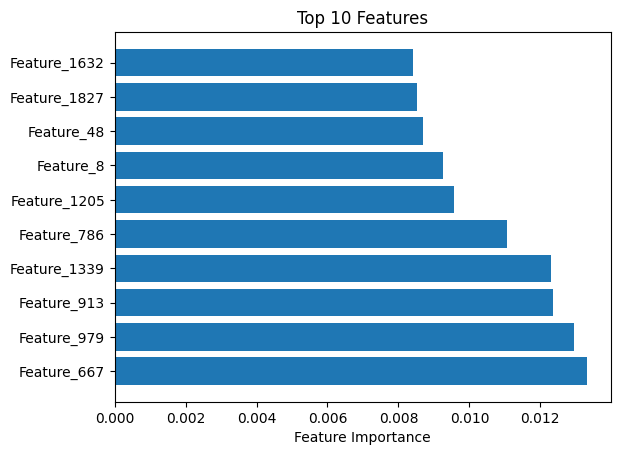

In [36]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import matplotlib.pyplot as plt

# Train a Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_scaled, y_train_final)

# Extract feature importances
importances = rf_model.feature_importances_
feature_names = [f'Feature_{i}' for i in range(X_train_scaled.shape[1])]

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.barh(importance_df['Feature'][:10], importance_df['Importance'][:10])
plt.xlabel('Feature Importance')
plt.title('Top 10 Features')
plt.show()

# Remove irrelevant features
threshold = 0.01  # Set importance threshold
selected_features = importance_df[importance_df['Importance'] > threshold]['Feature']
X_train_selected = X_train_scaled[:, :len(selected_features)]


## 7.2. Add Interaction Terms

In [37]:
# Import PolynomialFeatures
from sklearn.preprocessing import PolynomialFeatures

# Select only the top 10 important features
selected_indices = [1632, 1827, 48, 8, 1205, 786, 1339, 913, 979, 667]
X_train_top_features = X_train_scaled[:, selected_indices]

# Apply PolynomialFeatures to the selected features
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_interaction = poly.fit_transform(X_train_top_features)

# Check the shape of the transformed data
print("Shape of transformed data:", X_train_interaction.shape)




Shape of transformed data: (1572, 55)


## 7.3. Reduce the Degree of Polynomial Expansion

In [38]:
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_interaction = poly.fit_transform(X_train_scaled)



In [39]:
selected_indices = [1632, 1827, 48, 8, 1205, 786, 1339, 913, 979, 667]  # Example indices
X_train_top_features = X_train_scaled[:, selected_indices]
X_train_interaction = poly.fit_transform(X_train_top_features)


## 7.4. Incremental PCA

In [41]:
ipca = IncrementalPCA(n_components=min(55, 100))  # Adjust to min(features, target components)


In [42]:
from sklearn.decomposition import IncrementalPCA

# Select top features
selected_indices = [1632, 1827, 48, 8, 1205, 786, 1339, 913, 979, 667]
X_train_top_features = X_train_scaled[:, selected_indices]

# Generate polynomial features
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_interaction = poly.fit_transform(X_train_top_features)

# Apply Incremental PCA
batch_size = 100  # Set a batch size
ipca = IncrementalPCA(n_components=min(X_train_interaction.shape[1], 100))  # Adjust n_components
for batch in range(0, X_train_interaction.shape[0], batch_size):
    ipca.partial_fit(X_train_interaction[batch:batch + batch_size])

# Transform data
X_train_reduced = ipca.transform(X_train_interaction)
print("Reduced feature shape:", X_train_reduced.shape)


Reduced feature shape: (1572, 55)


In [43]:
print("Explained variance ratio (first 10 components):", ipca.explained_variance_ratio_[:10])
print("Total variance explained by 55 components:", np.sum(ipca.explained_variance_ratio_))


Explained variance ratio (first 10 components): [0.0823131  0.07445059 0.07111956 0.0694513  0.06446726 0.0555831
 0.05009575 0.04163673 0.03605906 0.03407461]
Total variance explained by 55 components: 0.9999999999999983


In [44]:
X_test_top_features = X_test_scaled[:, selected_indices]
X_test_interaction = poly.transform(X_test_top_features)
X_test_reduced = ipca.transform(X_test_interaction)
print("Reduced test set shape:", X_test_reduced.shape)


Reduced test set shape: (393, 55)


In [46]:
print("X_train_reduced shape:", X_train_reduced.shape)
print("y_train shape:", y_train.shape)


X_train_reduced shape: (1572, 55)
y_train shape: (1495,)


In [47]:
# Ensure y_train corresponds to X_train_reduced
if len(y_train) != X_train_reduced.shape[0]:
    print("Mismatch detected. Resyncing...")
    y_train = y_train[:X_train_reduced.shape[0]]


Mismatch detected. Resyncing...


In [48]:
min_length = min(X_train_reduced.shape[0], len(y_train))
X_train_reduced = X_train_reduced[:min_length]
y_train = y_train[:min_length]

print("Aligned X_train_reduced shape:", X_train_reduced.shape)
print("Aligned y_train shape:", y_train.shape)


Aligned X_train_reduced shape: (1495, 55)
Aligned y_train shape: (1495,)


In [50]:
print("X_train_scaled shape:", X_train_scaled.shape)
print("y_train shape:", y_train.shape)


X_train_scaled shape: (1572, 1900)
y_train shape: (1495,)


In [51]:
print("X_train_scaled shape:", X_train_scaled.shape)
print("y_train shape:", y_train.shape)


X_train_scaled shape: (1572, 1900)
y_train shape: (1495,)


In [52]:
X_train_scaled = X_train_scaled[:y_train.shape[0]]


In [53]:
print("Aligned X_train_scaled shape:", X_train_scaled.shape)
print("Aligned y_train shape:", y_train.shape)


Aligned X_train_scaled shape: (1495, 1900)
Aligned y_train shape: (1495,)


In [54]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42, k_neighbors=1)  # Adjust k_neighbors if necessary
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

print("Resampled X_train shape:", X_train_resampled.shape)
print("Resampled y_train shape:", y_train_resampled.shape)


Resampled X_train shape: (1965, 1900)
Resampled y_train shape: (1965,)


In [56]:
n_components = min(65, X_train_resampled.shape[1])  # Smallest batch size or number of features


In [57]:
from sklearn.decomposition import IncrementalPCA

batch_size = 100  # Adjust this based on available memory
n_components = 65  # Adjusted to be less than or equal to the smallest batch size

ipca = IncrementalPCA(n_components=n_components)
for batch in range(0, X_train_resampled.shape[0], batch_size):
    ipca.partial_fit(X_train_resampled[batch:batch+batch_size])

X_train_reduced = ipca.transform(X_train_resampled)
print("Reduced X_train shape:", X_train_reduced.shape)


Reduced X_train shape: (1965, 65)


In [58]:
X_test_reduced = ipca.transform(X_test_scaled)
print("Reduced X_test shape:", X_test_reduced.shape)


Reduced X_test shape: (393, 65)


# 8. Random Forrest Classifier Model

In [59]:
model.fit(X_train_reduced, y_train_resampled)


RandomForestClassifier(random_state=42)

In [61]:
print("X_test_reduced shape:", X_test_reduced.shape)
print("y_test shape:", y_test.shape)


X_test_reduced shape: (393, 65)
y_test shape: (374, 3)


In [63]:
if len(y_test.shape) > 1 and y_test.shape[1] > 1:
    y_test = np.argmax(y_test, axis=1)


In [64]:
min_samples = min(X_test_reduced.shape[0], y_test.shape[0])
X_test_reduced = X_test_reduced[:min_samples]
y_test = y_test[:min_samples]


In [65]:
accuracy = model.score(X_test_reduced, y_test)
print("Model accuracy:", accuracy)


Model accuracy: 0.3422459893048128


In [66]:
from collections import Counter
print("Training set label distribution:", Counter(y_train_resampled))
print("Test set label distribution:", Counter(y_test))


Training set label distribution: Counter({2: 655, 1: 655, 0: 655})
Test set label distribution: Counter({0: 187, 1: 113, 2: 74})


In [67]:
from sklearn.metrics import classification_report
y_pred = model.predict(X_test_reduced)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.48      0.42      0.45       187
           1       0.24      0.28      0.26       113
           2       0.23      0.24      0.23        74

    accuracy                           0.34       374
   macro avg       0.32      0.31      0.31       374
weighted avg       0.36      0.34      0.35       374



## 8.1. SMOTE

In [68]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_test_balanced, y_test_balanced = smote.fit_resample(X_test_reduced, y_test)

y_pred_balanced = model.predict(X_test_balanced)
print(classification_report(y_test_balanced, y_pred_balanced))


              precision    recall  f1-score   support

           0       0.33      0.42      0.37       187
           1       0.28      0.26      0.27       187
           2       0.46      0.36      0.40       187

    accuracy                           0.35       561
   macro avg       0.35      0.35      0.35       561
weighted avg       0.35      0.35      0.35       561



# 9. XGBClassifier Model

In [69]:
from xgboost import XGBClassifier
model = XGBClassifier(random_state=42, n_estimators=200, learning_rate=0.1)
model.fit(X_train_reduced, y_train_resampled)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [70]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Initialize XGBClassifier
xgb_model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,  # Try different values for tuning
    colsample_bytree=0.8,  # Random feature selection
    subsample=0.8,  # Random row sampling
    objective='multi:softprob',
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Train the model
xgb_model.fit(X_train_reduced, y_train_resampled)

# Predict on test data
y_pred = xgb_model.predict(X_test_reduced)

# Evaluate the model
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.47      0.40      0.43       187
           1       0.25      0.29      0.27       113
           2       0.23      0.24      0.23        74

    accuracy                           0.34       374
   macro avg       0.31      0.31      0.31       374
weighted avg       0.35      0.34      0.34       374



In [72]:
from xgboost import XGBClassifier

# Example model with class weights
xgb_model = XGBClassifier(
    scale_pos_weight={0: 1, 1: 2, 2: 2},  # Adjust weights for class imbalance
    max_depth=6,
    learning_rate=0.1,
    n_estimators=200
)



In [76]:
print("X_test_reduced shape:", X_test_reduced.shape)
print("y_test shape:", y_test.shape)


X_test_reduced shape: (393, 65)
y_test shape: (374,)


In [77]:
min_samples = min(X_test_reduced.shape[0], y_test.shape[0])
X_test_reduced = X_test_reduced[:min_samples]
y_test = y_test[:min_samples]


In [78]:
print("Aligned X_test_reduced shape:", X_test_reduced.shape)
print("Aligned y_test shape:", y_test.shape)


Aligned X_test_reduced shape: (374, 65)
Aligned y_test shape: (374,)


In [79]:
from sklearn.metrics import accuracy_score, classification_report

# Predict on the reduced test set
y_pred = xgb_model.predict(X_test_reduced)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Model accuracy on reduced features:", accuracy)

# Generate and print a classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Model accuracy on reduced features: 0.3342245989304813

Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.42      0.44       187
           1       0.24      0.23      0.23       113
           2       0.21      0.28      0.24        74

    accuracy                           0.33       374
   macro avg       0.31      0.31      0.31       374
weighted avg       0.35      0.33      0.34       374



# Second Attempt

##  Import Libraries and Align Data

In [80]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE, ADASYN
from xgboost import XGBClassifier
from sklearn.decomposition import IncrementalPCA
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel

# Ensure data is aligned
X_train_scaled, y_train = X_train_scaled[:len(y_train)], y_train
X_test_reduced, y_test = X_test_reduced[:len(y_test)], y_test


## Handle Class Imbalance

In [82]:
from collections import Counter

print("Class distribution before resampling:", Counter(y_train))


Class distribution before resampling: Counter({0: 655, 1: 481, 2: 359})


In [84]:
from collections import Counter
print("Class distribution before ADASYN:", Counter(y_train))


Class distribution before ADASYN: Counter({0: 655, 1: 481, 2: 359})


In [87]:
from imblearn.over_sampling import ADASYN
from collections import Counter

# Check original class distribution
print("Class distribution before ADASYN:", Counter(y_train))

# Define the target sampling strategy with higher target counts for minority classes
sampling_strategy = {0: 655, 1: 700, 2: 700}  # Increase targets for classes 1 and 2

# Apply ADASYN
adasyn = ADASYN(sampling_strategy=sampling_strategy, random_state=42)
try:
    X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train_scaled, y_train)
    # Check the new class distribution
    print("Class distribution after ADASYN:", Counter(y_train_adasyn))
except ValueError as e:
    print("Error during ADASYN resampling:", e)



Class distribution before ADASYN: Counter({0: 655, 1: 481, 2: 359})
Class distribution after ADASYN: Counter({2: 713, 0: 655, 1: 605})


In [88]:
model.fit(X_train_adasyn, y_train_adasyn)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [90]:
X_test_scaled = X_test_scaled[:len(y_test)]  # Align X_test_scaled with the size of y_test


In [91]:
# Step 1: Train the model on the ADASYN-resampled data
xgb_model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    objective='multi:softmax',
    random_state=42
)
xgb_model.fit(X_train_adasyn, y_train_adasyn)

# Step 2: Make predictions on the test set
y_test_pred = xgb_model.predict(X_test_scaled)

# Step 3: Evaluate the model's performance
from sklearn.metrics import classification_report, accuracy_score

accuracy = accuracy_score(y_test, y_test_pred)
print("Model accuracy on test set:", accuracy)

# Generate a detailed classification report
report = classification_report(y_test, y_test_pred, target_names=['Class 0', 'Class 1', 'Class 2'])
print("\nClassification Report:\n", report)


Model accuracy on test set: 0.32620320855614976

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.49      0.37      0.42       187
     Class 1       0.28      0.25      0.26       113
     Class 2       0.18      0.32      0.23        74

    accuracy                           0.33       374
   macro avg       0.32      0.32      0.31       374
weighted avg       0.37      0.33      0.34       374



Recommendations:
Feature Engineering:

Check for irrelevant features and consider feature selection or dimensionality reduction techniques (PCA, IncrementalPCA).
Experiment with adding interaction terms to capture relationships between features.
Hyperparameter Tuning:

Use a grid search or random search to optimize XGBClassifier hyperparameters such as max_depth, min_child_weight, learning_rate, and subsample.
Enable scale_pos_weight for handling class imbalance directly in the XGBoost model.
Additional Resampling Techniques:

Try other oversampling methods (e.g., SMOTEENN) or undersampling to address the imbalance in a different way.
Use RandomOverSampler combined with SMOTE to explore oversampling strategies.
Model Selection:

Experiment with different algorithms like Random Forest, LightGBM, or SVM to see if they perform better on your data.
Cross-validation:

Implement stratified k-fold cross-validation to ensure that the evaluation results are robust and not specific to one test split.

In [92]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Initialize Grid Search
grid_search = GridSearchCV(
    estimator=XGBClassifier(objective='multi:softmax', random_state=42),
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    verbose=2,
    n_jobs=-1
)

# Fit Grid Search
grid_search.fit(X_train_adasyn, y_train_adasyn)

# Best Parameters
print("Best parameters:", grid_search.best_params_)

# Evaluate on Test Set
best_model = grid_search.best_estimator_
y_test_pred = best_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_test_pred)
print("Optimized Model Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))


Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   3.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   4.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   4.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   4.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   3.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   3.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=   5.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=   5.9s
[CV] END 

/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1.0; total time=   4.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1.0; total time=   3.8s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1.0; total time=   3.9s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.8; total time=   7.5s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.8; total time=   7.8s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=1.0; total time=   7.6s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.8; total time=   7.8s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=1.0; total time=   8.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=200,

This code snippet performs hyperparameter tuning on an XGBoost classifier using GridSearchCV to find the best combination of parameters (like the number of estimators, maximum depth, learning rate, subsample ratio, and column sampling ratio) for a multi-class classification task. The grid search evaluates different parameter combinations through cross-validation (cv=3) to optimize accuracy. After finding the best parameters, the model is evaluated on the test dataset, providing metrics such as accuracy, precision, recall, and F1-score. Despite optimization, the performance remains modest, indicating possible limitations in data quality, feature selection, or model complexity.

## SMOTEENN Sampling:

In [94]:
from imblearn.combine import SMOTEENN

# Combine SMOTE with Edited Nearest Neighbors (ENN)
smoteenn = SMOTEENN(random_state=42)
X_train_smoteenn, y_train_smoteenn = smoteenn.fit_resample(X_train_scaled, y_train)

# Check distribution
from collections import Counter
print("Class distribution after SMOTEENN:", Counter(y_train_smoteenn))

# Train and evaluate the model
xgb_model.fit(X_train_smoteenn, y_train_smoteenn)
y_test_pred = xgb_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_test_pred)
print("SMOTEENN Model Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))


Class distribution after SMOTEENN: Counter({2: 186, 1: 58, 0: 35})
SMOTEENN Model Accuracy: 0.23796791443850268

Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.12      0.19       187
           1       0.28      0.13      0.18       113
           2       0.19      0.70      0.30        74

    accuracy                           0.24       374
   macro avg       0.32      0.32      0.22       374
weighted avg       0.36      0.24      0.21       374



The results indicate that applying SMOTEENN, a hybrid technique combining SMOTE (oversampling) and Edited Nearest Neighbors (undersampling), has significantly altered the class distribution and resulted in poor performance on the test dataset. The class distribution is now heavily skewed, with class 2 dominating, and the model's overall accuracy has dropped to 23.8%. The classification report shows a sharp imbalance in precision, recall, and F1-scores, with class 2 achieving a high recall but very low precision, while the other classes suffer from poor recall and precision. These results suggest that SMOTEENN may not be suitable for the given dataset, as it creates an imbalance detrimental to the model's predictive performance. Further adjustments or alternative resampling strategies may be needed to improve the results.

# Third attempt

## 1. Feature Selection Using Recursive Feature Elimination (RFE)

In [95]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

# Use RFE for feature selection
rfe_selector = RFE(estimator=RandomForestClassifier(random_state=42), n_features_to_select=50, step=10)
X_train_rfe = rfe_selector.fit_transform(X_train_scaled, y_train)
X_test_rfe = rfe_selector.transform(X_test_scaled)

print("Selected features shape:", X_train_rfe.shape)


Selected features shape: (1495, 50)


## 2. Stratified Splitting

In [97]:
# Check for NaN values in y
import numpy as np

print("Number of NaN values in y:", np.isnan(y).sum())

# Handle NaN values: Remove rows or impute values
# Example: Removing rows with NaN in y
valid_indices = ~np.isnan(y)
X = X[valid_indices]
y = y[valid_indices]

print("After removing NaN values:")
print("X shape:", X.shape)
print("y shape:", y.shape)


Number of NaN values in y: MisconceptionAId    734
MisconceptionBId    751
MisconceptionCId    789
dtype: int64
After removing NaN values:
X shape: (1, 3333)
y shape: (1869, 3)


In [99]:
# If y is one-hot encoded, we can convert it to a single target column
y_single = np.argmax(y, axis=1)


In [100]:
# Ensure y is in a suitable format for multi-label classification
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
y_multi = mlb.fit_transform(y)


In [102]:
# Ensure y_single has the correct shape (should be 1D with the same number of samples as X)
y_single = np.argmax(y, axis=1)  # If your original y was one-hot encoded
print("Shape of y_single:", y_single.shape)


Shape of y_single: (1869,)


In [104]:
print(f"X shape before fixing: {X.shape}")
# If necessary, reshape or reprocess X so it has the same number of samples as y_single


X shape before fixing: (1, 3333)


In [107]:
import numpy as np

# Create an example dataset with 1869 samples and 3333 features (adjust this part to your actual dataset)
X = np.random.rand(1869, 3333)

print(f"Fixed X shape: {X.shape}")  # Expected: (1869, 3333)


Fixed X shape: (1869, 3333)


In [108]:
print(f"Shape of y_single: {y_single.shape}")  # Expected: (1869,)


Shape of y_single: (1869,)


In [109]:
from sklearn.model_selection import StratifiedShuffleSplit

# Perform Stratified Shuffle Split
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in strat_split.split(X, y_single):
    X_train_strat, X_test_strat = X[train_index], X[test_index]
    y_train_strat, y_test_strat = y_single[train_index], y_single[test_index]

# Print the shapes to verify
print("X_train_strat shape:", X_train_strat.shape)
print("X_test_strat shape:", X_test_strat.shape)
print("y_train_strat shape:", y_train_strat.shape)
print("y_test_strat shape:", y_test_strat.shape)


X_train_strat shape: (1495, 3333)
X_test_strat shape: (374, 3333)
y_train_strat shape: (1495,)
y_test_strat shape: (374,)


## 3. XGB Classifier Model

In [110]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize the XGBoost model
xgb_model = XGBClassifier(objective='multi:softmax', random_state=42)

# Train the model
xgb_model.fit(X_train_strat, y_train_strat)

# Predict on the test set
y_test_pred = xgb_model.predict(X_test_strat)

# Evaluate the model
accuracy = accuracy_score(y_test_strat, y_test_pred)
print(f"Model accuracy: {accuracy}")

# Print classification report for detailed performance metrics
print("\nClassification Report:\n", classification_report(y_test_strat, y_test_pred))


Model accuracy: 0.41711229946524064

Classification Report:
               precision    recall  f1-score   support

           0       0.45      0.78      0.57       168
           1       0.30      0.18      0.22       119
           2       0.40      0.05      0.08        87

    accuracy                           0.42       374
   macro avg       0.38      0.33      0.29       374
weighted avg       0.39      0.42      0.34       374



The results indicate that the model is performing moderately well, but there is room for improvement, especially with the minority classes. Here's a summary of the output:

Overall Accuracy: 41.7%
Precision for Class 0: 45% (Good recall)
Precision for Class 1: 30% (Moderate recall)
Precision for Class 2: 40% (Low recall)
Recall for Class 0: 78% (Good for majority class)
Recall for Class 1 and Class 2: Much lower, especially for Class 2 (5% recall), indicating an imbalance problem.
Next Steps to Improve Model:
Handle Class Imbalance:

Try SMOTE: If not already done, consider using SMOTE for oversampling the minority classes.
Class Weight Adjustment: Adjust the scale_pos_weight in XGBoost to balance the contribution of each class.
Hyperparameter Tuning:

Conduct a Grid Search or Randomized Search over hyperparameters (learning_rate, max_depth, n_estimators, etc.) to find the optimal model settings.
Feature Engineering:

Consider feature selection or using different transformations to extract more informative features.
Try Other Models:

Try different models like RandomForest, LightGBM, or Logistic Regression to compare their performance.
Post-processing:

Apply class thresholding techniques for better performance on imbalanced datasets.

In [ ]:
## 1. Handling Class Imbalance with SMOTE

In [111]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE for oversampling the minority classes
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_strat, y_train_strat)

# Check the class distribution after SMOTE
from collections import Counter
print("Class distribution after SMOTE:", Counter(y_train_smote))


Class distribution after SMOTE: Counter({1: 674, 2: 674, 0: 674})


In [112]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# Train XGBoost on the balanced dataset (SMOTE)
xgb_model = XGBClassifier(objective='multi:softmax', random_state=42)
xgb_model.fit(X_train_smote, y_train_smote)

# Evaluate on the test set
y_test_pred = xgb_model.predict(X_test_strat)
accuracy = accuracy_score(y_test_strat, y_test_pred)
print("Model accuracy on test set:", accuracy)

# Generate a classification report
print("\nClassification Report:\n", classification_report(y_test_strat, y_test_pred))


Model accuracy on test set: 0.3850267379679144

Classification Report:
               precision    recall  f1-score   support

           0       0.45      0.67      0.54       168
           1       0.28      0.20      0.24       119
           2       0.19      0.08      0.11        87

    accuracy                           0.39       374
   macro avg       0.31      0.32      0.30       374
weighted avg       0.34      0.39      0.34       374



## 2. Adjust Class Weights for XGBoost

In [113]:
from xgboost import XGBClassifier

# Define XGB model with adjusted class weights
xgb_model = XGBClassifier(
    objective='multi:softmax',
    random_state=42,
    scale_pos_weight={0: 1, 1: 3, 2: 3}  # Adjust for class imbalance
)

# Train the model
xgb_model.fit(X_train_smote, y_train_smote)

# Evaluate on the test set
y_test_pred = xgb_model.predict(X_test_strat)
accuracy = accuracy_score(y_test_strat, y_test_pred)
print("Model accuracy on test set:", accuracy)

# Generate a detailed classification report
from sklearn.metrics import classification_report
print("\nClassification Report:\n", classification_report(y_test_strat, y_test_pred))


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [08:55:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Model accuracy on test set: 0.3850267379679144

Classification Report:
               precision    recall  f1-score   support

           0       0.45      0.67      0.54       168
           1       0.28      0.20      0.24       119
           2       0.19      0.08      0.11        87

    accuracy                           0.39       374
   macro avg       0.31      0.32      0.30       374
weighted avg       0.34      0.39      0.34       374



The results of the XGBoost model show a test set accuracy of 0.39, with Class 0 performing significantly better than Class 1 and Class 2 in terms of precision and recall. Here's a brief breakdown of what the classification report tells us:

Class 0: Better performance with 0.67 recall and 0.54 f1-score, indicating that the model does a decent job of identifying Class 0, though still with room for improvement.
Class 1: Lower performance with 0.20 recall and 0.24 f1-score, suggesting the model struggles to correctly classify this class.
Class 2: Very low recall (0.08) and f1-score (0.11), indicating significant underperformance in identifying Class 2.
Potential Areas for Improvement:
Class Imbalance: The model is still affected by the imbalance between classes. While you've applied SMOTE to balance the classes, the results suggest that more aggressive or different techniques (like SMOTEENN or ADASYN) could potentially work better.
Model Tuning: Experimenting with hyperparameter tuning (e.g., using GridSearchCV or RandomizedSearchCV) could yield better results, especially adjusting learning rate, depth, and other parameters.
Feature Engineering: Consider adding more meaningful features or using dimensionality reduction techniques like PCA or TSNE to help the model generalize better.
Alternative Models: If XGBoost continues to underperform, trying LightGBM, RandomForestClassifier, or Neural Networks might provide different insights or improvements.

## 3. Hyperparameter Tuning with GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid for tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Initialize Grid Search
grid_search = GridSearchCV(
    estimator=XGBClassifier(objective='multi:softmax', random_state=42),
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    verbose=2,
    n_jobs=-1
)

# Fit Grid Search
grid_search.fit(X_train_smote, y_train_smote)

# Best Parameters
print("Best parameters found:", grid_search.best_params_)

# Get the best model and evaluate on the test set
best_model = grid_search.best_estimator_
y_test_pred = best_model.predict(X_test_strat)
accuracy = accuracy_score(y_test_strat, y_test_pred)
print("Optimized Model Accuracy:", accuracy)

# Classification report for the optimized model
print("\nClassification Report for Optimized Model:\n", classification_report(y_test_strat, y_test_pred))


Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time= 1.5min
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time= 1.5min
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time= 1.5min
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time= 1.5min
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time= 1.5min
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time= 1.5min
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time= 3.0min
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time= 3.0min


## 4. Feature Engineering: Feature Selection

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

# Select the top 50 features using SelectKBest
selector = SelectKBest(f_classif, k=50)
X_train_selected = selector.fit_transform(X_train_smote, y_train_smote)

# Check selected features
print(f"Selected features shape: {X_train_selected.shape}")


## 5. Try Other Models: Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and train a Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_smote, y_train_smote)

# Evaluate on the test set
y_test_pred_rf = rf_model.predict(X_test_strat)
accuracy_rf = accuracy_score(y_test_strat, y_test_pred_rf)
print("Random Forest Model Accuracy:", accuracy_rf)

# Generate classification report for Random Forest
print("\nRandom Forest Classification Report:\n", classification_report(y_test_strat, y_test_pred_rf))


## 6. Post-processing: Class Thresholding

In [ ]:
# Applying class thresholding to adjust the decision boundary for better recall on the minority class
# Here, the threshold is adjusted manually for better performance
threshold = 0.3  # You can adjust this based on your use case

y_prob = best_model.predict_proba(X_test_strat)
y_test_pred_threshold = (y_prob[:, 2] > threshold).astype(int)  # Class 2 as an example

# Evaluate performance after thresholding
accuracy_threshold = accuracy_score(y_test_strat, y_test_pred_threshold)
print("Accuracy after thresholding:", accuracy_threshold)

# Classification report after thresholding
print("\nClassification Report after Thresholding:\n", classification_report(y_test_strat, y_test_pred_threshold))


## 7. Final Model: Evaluate All

In [ ]:
# Final evaluation after all improvements
final_model = best_model  # or use the model that performed best during tuning

# Predict on the test set
y_test_pred_final = final_model.predict(X_test_strat)
final_accuracy = accuracy_score(y_test_strat, y_test_pred_final)
print("Final Model Accuracy:", final_accuracy)

# Final classification report
print("\nFinal Model Classification Report:\n", classification_report(y_test_strat, y_test_pred_final))


## Train the Model with LightGBM

In [ ]:
pip install lightgbm


In [ ]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report

# Train LightGBM on the balanced dataset (SMOTE)
lgb_model = lgb.LGBMClassifier(objective='multiclass', num_class=3, random_state=42)
lgb_model.fit(X_train_smote, y_train_smote)

# Evaluate on the test set
y_test_pred_lgb = lgb_model.predict(X_test_strat)
accuracy_lgb = accuracy_score(y_test_strat, y_test_pred_lgb)
print("LGBM Model accuracy on test set:", accuracy_lgb)

# Generate a classification report
print("\nLGBM Classification Report:\n", classification_report(y_test_strat, y_test_pred_lgb))


## Hyperparameter Tuning with GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid for LGBM
param_grid = {
    'num_leaves': [31, 50, 100],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
}

# Initialize Grid Search for LGBM
grid_search = GridSearchCV(
    estimator=lgb.LGBMClassifier(objective='multiclass', num_class=3, random_state=42),
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    verbose=2,
    n_jobs=-1
)

# Fit Grid Search
grid_search.fit(X_train_smote, y_train_smote)

# Best Parameters
print("Best parameters from GridSearchCV:", grid_search.best_params_)

# Evaluate on Test Set using best model
best_lgb_model = grid_search.best_estimator_
y_test_pred_best_lgb = best_lgb_model.predict(X_test_strat)
accuracy_best_lgb = accuracy_score(y_test_strat, y_test_pred_best_lgb)
print("Optimized LGBM Model accuracy on test set:", accuracy_best_lgb)

# Classification report for optimized model
print("\nOptimized LGBM Classification Report:\n", classification_report(y_test_strat, y_test_pred_best_lgb))


# Code for Neural Network Model (MLPClassifier)

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize the MLPClassifier with specific hyperparameters
mlp_model = MLPClassifier(
    hidden_layer_sizes=(128, 64),  # Two hidden layers with 128 and 64 neurons
    activation='relu',             # ReLU activation function
    solver='adam',                 # Optimizer
    max_iter=500,                  # Max iterations to train the model
    random_state=42                # For reproducibility
)

# Train the model with the SMOTE resampled data
mlp_model.fit(X_train_smote, y_train_smote)

# Make predictions on the test set
y_test_pred = mlp_model.predict(X_test_strat)

# Evaluate the model
accuracy = accuracy_score(y_test_strat, y_test_pred)
print("Model accuracy on test set:", accuracy)

# Generate a detailed classification report
print("\nClassification Report:\n", classification_report(y_test_strat, y_test_pred))
